<a href="https://colab.research.google.com/github/harrisb002/GrainBoundaryDetection/blob/Masks/Joels_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import scipy
import scipy.ndimage as ndi
import numpy as np
import skimage
from skimage import io, filters
from skimage import data, img_as_float
import skimage.util.noise as noise
from skimage.restoration import denoise_bilateral
import matplotlib.pyplot as plt
import os
import math

import skimage
from skimage import img_as_ubyte
from skimage import exposure
from skimage import filters
from skimage import io
from skimage import color
from skimage import feature
from skimage import segmentation
from skimage import morphology
import scipy.ndimage as ndi
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Only Run the below cell Once to create si_ka.png image from the Si Kα1.csv file
---


In [ ]:
import sys
from numpy import genfromtxt
from PIL import Image


def extract_filename(fpath: str) -> str:
    end = len(fpath) - 1
    while end >= 0:
        if fpath[end] == '.':
            end -= 1
            break
        end -= 1
    start = end
    while start >= 0:
        if fpath[start] == '/':
            break
        start -= 1
    return fpath[start + 1:end + 1]


if __name__ == '__main__':
    if len(sys.argv) != 3:
        sys.stderr.write('Invalid arguments -- Source path and destination required')
    # filepath = sys.argv[1]
    # filename = extract_filename(filepath) + '.png'
    # destination = sys.argv[2]

    img_data = genfromtxt("/content/drive/MyDrive/Grain Boundary Detection/data/Si Kα1.csv", delimiter=',')
    img_png = Image.fromarray(img_data)
    img_png = img_png.convert('RGB')
    img_png.save("/content/drive/MyDrive/Grain Boundary Detection/cs479_Joels_playground/images/si_ka.png")

# python3 -m csv_to_img.py someCSV.csv images/si_ka.png

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.config.list_physical_devices('GPU')

Num GPUs Available:  0


[]

# Note: May need to change filepath based upon your folder structure
- i.e. "/content....'


[[  0   7   9 ... 103 137 116]
 [  0   8   8 ... 116 127 112]
 [  0   8  11 ... 128 123 118]
 ...
 [ 35  29  25 ... 140 137 147]
 [ 35  34  27 ... 141 142 138]
 [ 29  38  35 ... 137 139 125]]
[[0.02214711 0.02409052 0.02687876 ... 0.46354695 0.46462363 0.46489975]
 [0.02236159 0.02429693 0.02723011 ... 0.46275312 0.46391699 0.4645828 ]
 [0.02271779 0.02480582 0.02752865 ... 0.46171478 0.4639592  0.46487133]
 ...
 [0.13380567 0.13642295 0.1431769  ... 0.55972751 0.5575168  0.55598485]
 [0.1345892  0.13785512 0.14402979 ... 0.56055407 0.55634718 0.55420616]
 [0.13500074 0.13877374 0.14589075 ... 0.5599588  0.55535339 0.55248916]]
[[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [252 252 251 ... 255   0   0]
 [252 251 251 ...   0   0   0]
 [252 251 251 ...   0   0   0]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


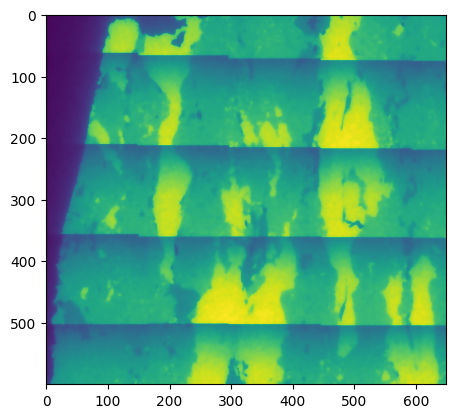

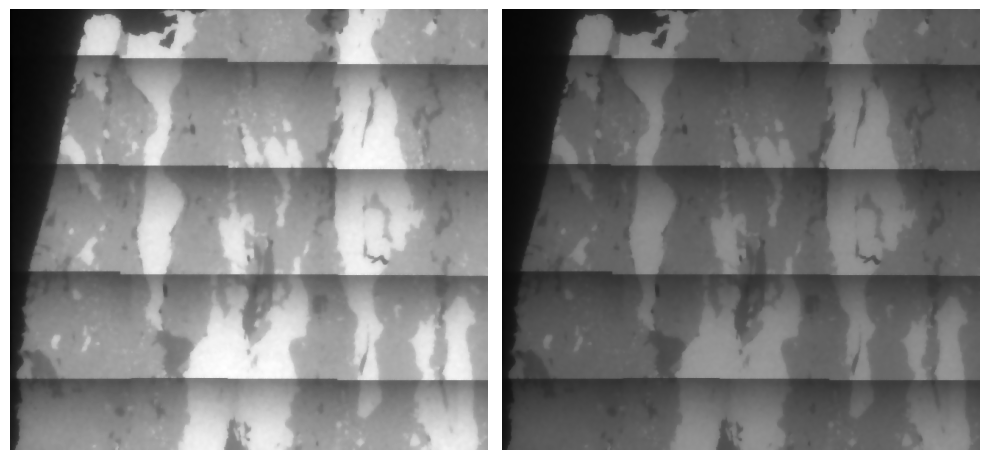

In [ ]:
# REGION BASED SEGMENTATION
#
# NOTE: looks a lot line canny, but less skeletal.... smoother. white rings at near grain boundaries
filename = "/content/drive/MyDrive/Grain Boundary Detection/cs479_Joels_playground/images/si_ka.png"
grains = io.imread(filename)
grains_cropped = grains[100:700,:650,2]
# grains_equalized = (skimage.exposure.equalize_hist(grains_cropped) * 255).astype(np.uint8)
grains_equalized = skimage.restoration.denoise_tv_chambolle(grains_cropped)
plt.imshow(grains_equalized)
elevation_map = (filters.difference_of_gaussians(grains_equalized,3) * 255).astype(np.uint8)
print(grains_cropped)
print(grains_equalized)
print(elevation_map)
#
# NOTE: looks like shit, but recall that you can densify or sparsen the number of markers
markers = np.zeros_like(grains_equalized)
markers[grains_equalized < 1] = 1
markers[grains_equalized > 250] = 2
markers = markers.astype(int)
print(markers)

#
# NOTE: Pretty decent mask. BINARY IMAGE. few holes in the problem coin (the one that remained canny in edge-based example)
segmentation_grains = segmentation.watershed(elevation_map, markers)
#
#
# NOTE: filling holes after watershed,
# NOTE: Using ndi.label on watershed binary image instead of morphology.label on local maxi dots.
#       Getting entire coins as labels instead of little dots.
# NOTE: Label RGB turns up the rainbow
segmentation_grains = ndi.binary_fill_holes(segmentation_grains - 1)
labeled_grains, _ = ndi.label(segmentation_grains)
image_label_overlay = color.label2rgb(labeled_grains, image=grains_equalized, bg_label=0)
#
#
# NOTE: The contour method puts this magical yellow ring around coins, and seems to impact image_label_overlay as well?
#       NOTE ASK GILL
fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharey=True)
axes[0].imshow(grains_equalized, cmap=plt.cm.gray)
axes[0].contour(segmentation_grains, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay)
#
for a in axes:
    a.axis('off')
plt.tight_layout()
plt.show()


# SLIC Segmentation

(3272, 1883, 3)
(3272, 1883, 3)
(3272, 1883, 3) float64


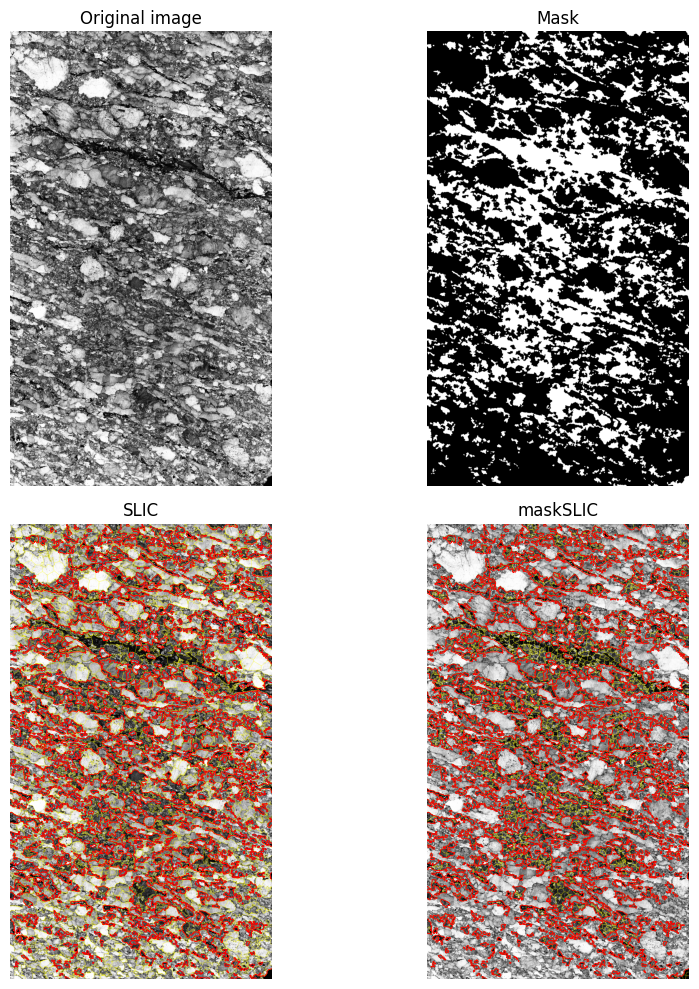

In [ ]:

# filename = "./si_ka.png"
# filename = "./11CSR01-p-(Si).bmp"
filename = "/content/drive/MyDrive/Grain Boundary Detection/cs479_Joels_playground/images/cropped_band_image.png"

grains = io.imread(filename)
grains_cropped = grains[:,:,:3]
# grains_cropped = grains[:650,:650,:3]
print(grains_cropped.shape)
# grains_cropped = grains[:650,:650,:]
# print(grains_cropped.dtype)
# restored = np.empty_like(grains_cropped)
# restored = grains_cropped
# for i in range(restored.shape[2]):
    # restored[:,:,i]= skimage.restoration.denoise_tv_chambolle(grains_cropped[:,:,i])

grains_equalized = (skimage.exposure.equalize_hist(grains_cropped) * 255).astype(np.uint8)
print(grains_equalized.shape)
lum = color.rgb2gray(grains_equalized)
mask = morphology.remove_small_holes(
    morphology.remove_small_objects(
        # lum < 0.30, 500), 500)
        lum < 0.37, 500), 500)

mask = morphology.opening(mask, morphology.disk(3))

# SLIC result
slic = segmentation.slic(grains_equalized,  n_segments=2000, start_label=1, max_num_iter=30, sigma=2)

# maskSLIC result
m_slic = segmentation.slic(grains_equalized, n_segments=2000, mask=mask, start_label=1, max_num_iter=30, sigma=1)

seg = segmentation.mark_boundaries(grains_equalized, slic)
print(seg.shape, seg.dtype)

grains_marked = (segmentation.mark_boundaries(grains_equalized, slic)* 255).astype(np.uint8)
grains_mask_marked = (segmentation.mark_boundaries(grains_equalized, m_slic) * 255).astype(np.uint8)

# Save images
io.imsave('/content/drive/MyDrive/Grain Boundary Detection/cs479_Joels_playground/images/band_contrast_slic_equalized.png', grains_marked)
io.imsave('/content/drive/MyDrive/Grain Boundary Detection/cs479_Joels_playground/images/band_contrast_slick_eqaulized_mask.png', grains_mask_marked)

# Display result
fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
ax1, ax2, ax3, ax4 = ax_arr.ravel()

ax1.imshow(grains_equalized)
ax1.set_title('Original image')

ax2.imshow(mask, cmap='gray')
ax2.set_title('Mask')

ax3.imshow(segmentation.mark_boundaries(grains_equalized, slic))
ax3.contour(mask, colors='red', linewidths=0.5)
ax3.set_title('SLIC')

ax4.imshow(segmentation.mark_boundaries(grains_equalized, m_slic))
ax4.contour(mask, colors='red', linewidths=0.5)
ax4.set_title('maskSLIC')

for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

# Edge Detection (Canny)

(3272, 1883, 3)
(3272, 1883, 3)


<ipython-input-30-e1ecafeede58>:30: UserWarning: /content/drive/MyDrive/Grain Boundary Detection/cs479_Joels_playground/images/band_contrast_canny_equalized.png is a low contrast image
  io.imsave('/content/drive/MyDrive/Grain Boundary Detection/cs479_Joels_playground/images/band_contrast_canny_equalized.png', canny_grains)


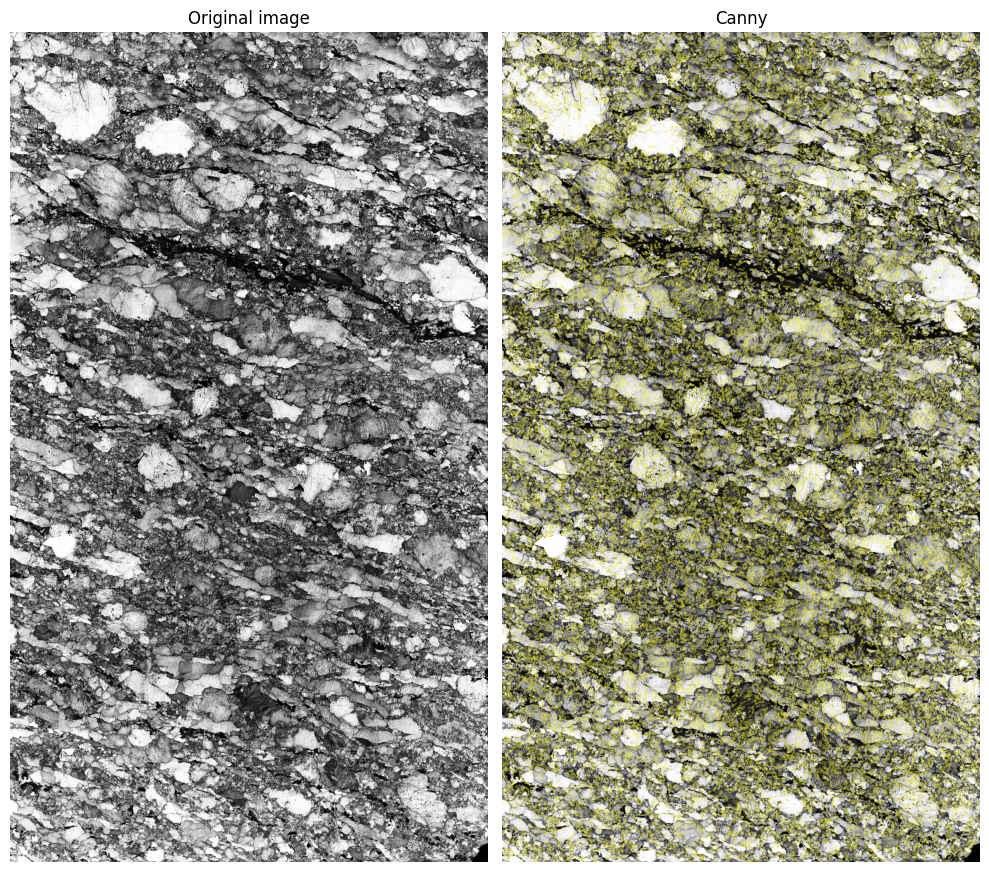

In [ ]:

# filename = "./si_ka.png"
# filename = "./11CSR01-p-(Si).bmp"
filename = '/content/drive/MyDrive/Grain Boundary Detection/cs479_Joels_playground/images/cropped_band_image.png'

grains = io.imread(filename)
grains_cropped = grains[:,:,:3]
# grains_cropped = grains[:650,:650,:3]
print(grains_cropped.shape)
# grains_cropped = grains[:650,:650,:]
# print(grains_cropped.dtype)
# restored = np.empty_like(grains_cropped)
# restored = grains_cropped
# for i in range(restored.shape[2]):
    # restored[:,:,i]= skimage.restoration.denoise_tv_chambolle(grains_cropped[:,:,i])

grains_equalized = (skimage.exposure.equalize_hist(grains_cropped) * 255).astype(np.uint8)
print(grains_equalized.shape)

lum = color.rgb2gray(grains_equalized)
# mask = morphology.remove_small_holes(
    # morphology.remove_small_objects(
        # lum < 0.30, 500), 500)
        # lum < 0.7, 500), 500)

edges = skimage.feature.canny(lum)
filled_grains = ndi.binary_fill_holes(edges)
canny_grains = ndi.label(skimage.morphology.remove_small_objects(filled_grains, 21))[0]

# Save images
io.imsave('/content/drive/MyDrive/Grain Boundary Detection/cs479_Joels_playground/images/band_contrast_canny_equalized.png', canny_grains)

# Display result
fig, ax_arr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 10))
ax1, ax2 = ax_arr.ravel()

ax1.imshow(grains_equalized)
ax1.set_title('Original image')

ax2.imshow(segmentation.mark_boundaries(grains_equalized, canny_grains))
ax2.set_title('Canny')

for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

# Watershed

(3272, 1883, 3)
(3272, 1883, 3)
(3272, 1883) uint8


<ipython-input-32-ebf8e0a77192>:33: UserWarning: /content/drive/MyDrive/Grain Boundary Detection/cs479_Joels_playground/images/band_contrast_watershed_equalized.png is a low contrast image
  io.imsave('/content/drive/MyDrive/Grain Boundary Detection/cs479_Joels_playground/images/band_contrast_watershed_equalized.png', watershed_grains)


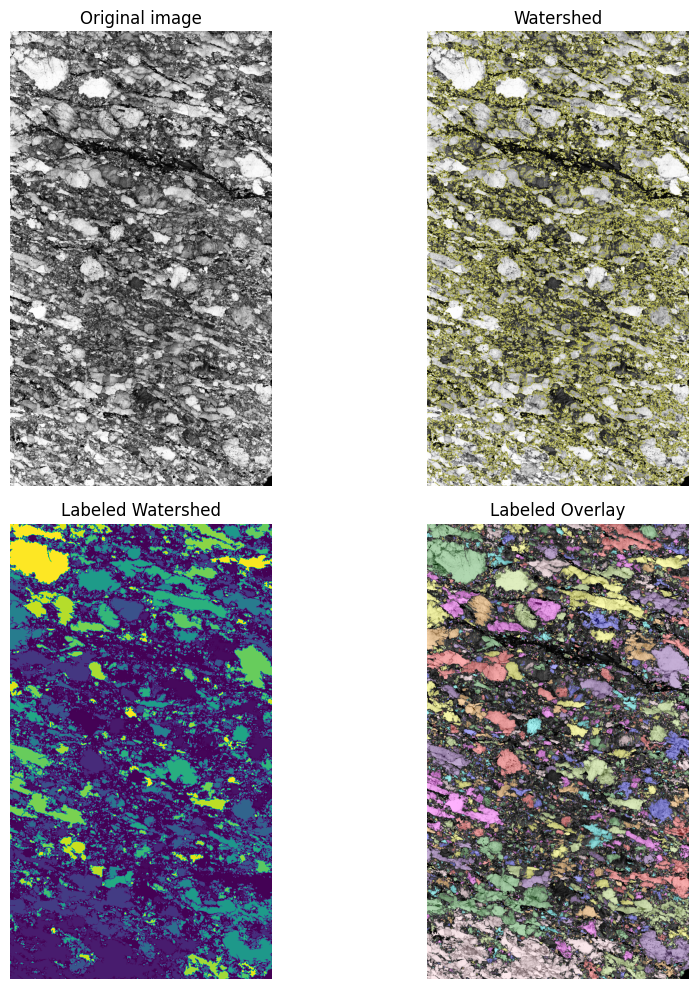

In [ ]:

# filename = "./si_ka.png"
# filename = "./11CSR01-p-(Si).bmp"
filename = '/content/drive/MyDrive/Grain Boundary Detection/cs479_Joels_playground/images/cropped_band_image.png'

grains = io.imread(filename)
grains_cropped = grains[:,:,:3]
# grains_cropped = grains[:650,:650,:3]
print(grains_cropped.shape)
# grains_cropped = grains[:650,:650,:]
# print(grains_cropped.dtype)
# restored = np.empty_like(grains_cropped)
# restored = grains_cropped
# for i in range(restored.shape[2]):
    # restored[:,:,i]= skimage.restoration.denoise_tv_chambolle(grains_cropped[:,:,i])

grains_equalized = (skimage.exposure.equalize_hist(grains_cropped) * 255).astype(np.uint8)
print(grains_equalized.shape)

gray_grains = (color.rgb2gray(grains_equalized)* 255).astype(np.uint8)
print(gray_grains.shape, gray_grains.dtype)

elevation_map = skimage.filters.sobel(gray_grains)
markers = np.zeros_like(gray_grains)
markers[gray_grains < 100] = 1
markers[gray_grains > 160] = 2
watershed_grains = segmentation.watershed(elevation_map, markers)
watershed_grains = ndi.label(ndi.binary_fill_holes(watershed_grains - 1))[0]

labeled_grains = (skimage.measure.label(watershed_grains)* 255).astype(np.uint8)
labeled_overlay = (skimage.color.label2rgb(labeled_grains, image=grains_equalized, bg_label=0)* 255).astype(np.uint8)

# Save images
io.imsave('/content/drive/MyDrive/Grain Boundary Detection/cs479_Joels_playground/images/band_contrast_watershed_equalized.png', watershed_grains)
io.imsave('/content/drive/MyDrive/Grain Boundary Detection/cs479_Joels_playground/images/band_contrast_watershed_labeled.png', labeled_grains)
io.imsave('/content/drive/MyDrive/Grain Boundary Detection/cs479_Joels_playground/images/band_contrast_watershed_overlay.png', labeled_overlay)

# Display result
fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
ax1, ax2, ax3, ax4 = ax_arr.ravel()

ax1.imshow(grains_equalized)
ax1.set_title('Original image')

ax2.imshow(segmentation.mark_boundaries(gray_grains, watershed_grains))
ax2.set_title('Watershed')

ax3.imshow(labeled_grains)
ax3.set_title('Labeled Watershed')

ax4.imshow(labeled_overlay)
ax4.set_title('Labeled Overlay')

for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()